In [17]:
from sklearn.linear_model import ElasticNet
import joblib 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd


# Prepare data

In [18]:
def predict_tAge(data, model):
    features = model.feature_names
    data_for_calculation = data[features]
    tAge = model.predict(data_for_calculation)
    
    return tAge

## Mouse

In [19]:
# from utils.structure import load_structure
# udf = load_structure('data/ultradf_v4.json')

In [57]:
clocks = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))
data = pd.read_csv('clocks/mouse_exprs_norm_final_29ds.csv', index_col=0)
annot = pd.read_csv('clocks/mouse_data_annotation_29ds.csv', index_col=1)


/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [58]:
mouse_clock_age_norm = predict_tAge(data, clocks)
annot['AgeNorm'] = mouse_clock_age_norm
annot = annot.drop('Unnamed: 0', 1)

/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [59]:
annot.to_csv('clocks/Mouse_clock_output.csv')

## Human

In [54]:
clocks = joblib.load(open('clocks/Aging_human_norm.pkl', 'rb'))
data = pd.read_csv('clocks/human_exprs_norm_final.csv', index_col=0)
annot = pd.read_csv('clocks/human_data_annotation.csv', index_col=1)


/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [55]:
human_clock_age_norm = predict_tAge(data, clocks)
annot['AgeNorm'] = human_clock_age_norm
annot = annot.drop('Unnamed: 0', 1)

/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [56]:
annot.to_csv('clocks/Human_clock_output.csv')

# Explore clocks

In [ ]:
model_name = 'Aging_mouse_norm'
model = joblib.load(open('clocks/%s.pkl' % model_name, 'rb'))
age = pd.read_csv('subdata/gene_atlas_aging.csv')
aging_genes = age['Symbol'].tolist()

In [2]:
coef = model.coef_
genes = np.array(model.feature_names)


In [3]:
ids = np.nonzero(coef)[0]
coef = coef[ids]
genes = genes[ids]

In [4]:
len(genes)

337

In [5]:
#rep = pd.read_csv('reprogramming_mouse_full.csv', index_col=0)

In [6]:
import mygene
raw = genes.tolist()
key = 'entrezgene'
species = 'mouse'
query_key = 'symbol'

def key2key(raw, key, query_key, species):
    mg = mygene.MyGeneInfo()
    query = mg.querymany(raw, scopes=key, species=species, verbose=False)   

    ref2entrez = {r:[] for r in raw}
    for r, q in zip(raw, query):
        if query_key in q:
            ref2entrez[r].append(q[query_key])
        else:
            ref2entrez[r] = None

    print('Max number of ENTREZ across keys:', 
            max([len(ref2entrez[r]) for r in ref2entrez.keys() if ref2entrez[r] is not None]))

    ref2entrez = {k:v[0] for k,v in ref2entrez.items() if (v is not None) and (len(v)==1)}
    return ref2entrez

In [7]:
ref2key = key2key(raw, key, query_key, species)
genesym = np.array([ref2key[k] for k in raw])

Max number of ENTREZ across keys: 1


In [8]:
len(coef), len(genesym)

(337, 337)

In [9]:
ids_sort = np.argsort(coef)[::-1]
coef_sort = coef[ids_sort]
gene_sort = genesym[ids_sort]

In [10]:
wei = pd.DataFrame({'coef':coef_sort, 'gene':gene_sort})
wei = wei.set_index('gene')

In [11]:
wei 

,coef
gene,
Lyz2,0.039848
Rbm3,0.032041
Amy1,0.030675
S100a6,0.029979
Snhg11,0.028876
...,...
Coro1a,-0.031212
Col3a1,-0.036810
Ezh2,-0.038060


In [12]:
wei_age = wei.loc[set(gene_sort).intersection(aging_genes)].sort_values('coef', ascending=False)
wei_age = wei_age.reset_index()

<AxesSubplot:title={'center':'Aging_mouse_norm genes in GenAge'}, xlabel='coef', ylabel='gene'>

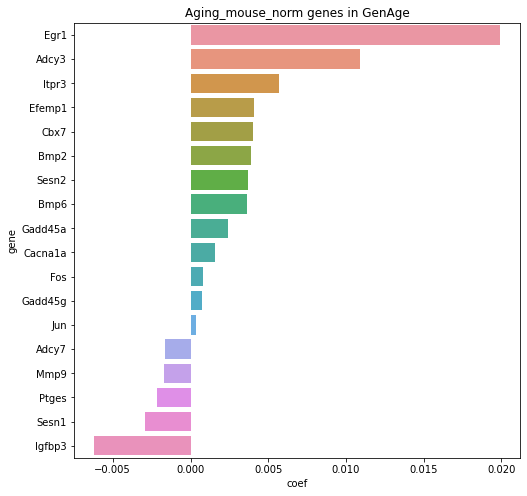

In [13]:
plt.figure(figsize=(8,8))
plt.title('%s genes in GenAge' % model_name)
sns.barplot(data=wei_age, x='coef', y='gene', orient='h')

In [54]:
m = [[len(wei_age), len(aging_genes) - len(wei_age), ],
    [len(wei) - len(wei_age), len(model.coef_) - len(aging_genes) - len(wei) + len(wei_age)]]

from scipy.stats import fisher_exact
fisher_exact(m)

(1.105603448275862, 0.6981679045434946)

In [152]:
#tmpdict = {"Aging_mouse_norm":gene_sort}

In [165]:
tmpdict[model_name] = gene_sort

In [188]:
set(tmpdict['Aging_mouse_norm']).intersection(set(tmpdict['Aging_mouse_scaled'])).intersection(aging_genes)

{'Adcy3',
 'Bmp6',
 'Cacna1a',
 'Efemp1',
 'Egr1',
 'Fos',
 'Gadd45a',
 'Gadd45g',
 'Igfbp3',
 'Itpr3',
 'Mmp9',
 'Ptges',
 'Sesn1',
 'Sesn2'}